# Machine learning: exam assignment
### Predicting Marvel vs DC

#### Student: Jeroen Van Sweeveldt
##### Assignment: binary classification, predicting the creator of the respective superhero using the 'history_text' feature.
##### Part 2: training classical algorithms

### 1 Model preparation

In [1]:
# imports for data exploration
import numpy as np
import pandas as pd

# imports for data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pprint as pp

# imports for classifiers
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler

from sklearn import set_config

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# imports for evaluation
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

print(f"Sklearn == {sklearn.__version__}")

Sklearn == 1.3.2


In [2]:
# open the dataset as a comma separated values file
heroes = pd.read_csv("data/heroes_preprocessed.csv",
                     encoding="UTF-8",
                     usecols=["creator",
                              "hist_text_classic",
                              "label"
                              ])

In [3]:
heroes.sample(10)

,hist_text_classic,creator,label
1513,xavi father make statue magneto professor x gi...,Marvel Comics,1
1358,"2006 "" civil war "" storyline , misty knight co...",Marvel Comics,1
55,aaron helzinger giant man prone fit homicidal ...,DC Comics,0
1607,"soldier fail kill vicki vale , ra al ghul deci...",DC Comics,0
63,"aldrif odinsdottir firstborn odin freyja , hei...",Marvel Comics,1
189,daughter david cain sandra wu - san ( lady shi...,DC Comics,0
1275,"john jameson , son newspaper mogul j. jonah ja...",Marvel Comics,1
1297,"appear feeling wonder girl , claim "" hate wond...",DC Comics,0
680,early life n'jadaka father press work villain ...,Marvel Comics,1
570,"note read , "" - . "" deathstroke found me...",DC Comics,0


In [4]:
# account for the data imbalance
c_weights = {0: 1.45, 1: 1.0}

Given the size of the dataset, I will perform an 80/10/10 split. With classical algorithms, we were taught to split the dataset in two sets, a train and test set, but since a neural network comes into play, I will split the data in three sets, a train, development, and test set.

We were never shown how to apply this in a situation in which both a classical and neural algorithm were used, but my reasoning, based on what we were taught in the lectures, is that you can only perform a single train-test-split. (That means, no split with two sets for the classical and another split with three sets for the neural, as I imagine some people would do). Otherwise the results of our training will be unreliable, as we'll end up with different data distributions.

Since the development set is used in the neural network as a substitute for the classical ML's cross-validation, I will perform the grid search for the classical algorithms on the dev set.

In [5]:
X_text = heroes.hist_text_classic
y_label = heroes.label


X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_text, y_label, test_size=0.2,
                                                    random_state=256, stratify=y_label)

X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test, y_dev_test, test_size=0.5,
                                                    random_state=256, stratify=y_dev_test)

X_train.shape, X_dev.shape, X_test.shape, y_train.shape, y_dev.shape, y_test.shape

((1853,), (232,), (232,), (1853,), (232,), (232,))

In [6]:
set_config(display="diagram")

vect = TfidfVectorizer(analyzer="word", max_features=512)
# we're going to use the RobustScaler because neither the
# StandardScaler nor MinMaxScaler support sparse matrices
# (the former cannot center the data in sparse matrices)
# moreover, it yields better performance than the MaxAbsScaler
# on the Logistic Regression model tests
# this is probably due to the RobustScaler's ability to
# handle outliers
scaler = RobustScaler(with_centering=False)

logreg = LogisticRegression(max_iter=5120, random_state=256)
knn = KNeighborsClassifier()
svm = SVC(random_state=256)
nb = MultinomialNB()

logreg_pipe = make_pipeline(vect, scaler, logreg)
knn_pipe = make_pipeline(vect, scaler, knn)
svm_pipe = make_pipeline(vect, scaler, svm)
nb_pipe = make_pipeline(vect, scaler, nb)

# baseline classifier:
dummy = DummyClassifier(strategy="stratified", random_state=256)

dummy_pipe = make_pipeline(vect, scaler, dummy)

#### 1.2 Baseline

In [7]:
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=512)),
                ('robustscaler', RobustScaler(with_centering=False)),
                ('dummyclassifier',
                 DummyClassifier(random_state=256, strategy='stratified'))])

In [8]:
y_test_pred_dummy = dummy_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred_dummy))

              precision    recall  f1-score   support

           0       0.41      0.38      0.40        95
           1       0.59      0.63      0.61       137

    accuracy                           0.53       232
   macro avg       0.50      0.50      0.50       232
weighted avg       0.52      0.53      0.52       232



### 2 Model training
#### 2.1 Logistic Regression

In [9]:
pp.pprint(sorted(logreg_pipe.get_params().keys()))

['logisticregression',
 'logisticregression__C',
 'logisticregression__class_weight',
 'logisticregression__dual',
 'logisticregression__fit_intercept',
 'logisticregression__intercept_scaling',
 'logisticregression__l1_ratio',
 'logisticregression__max_iter',
 'logisticregression__multi_class',
 'logisticregression__n_jobs',
 'logisticregression__penalty',
 'logisticregression__random_state',
 'logisticregression__solver',
 'logisticregression__tol',
 'logisticregression__verbose',
 'logisticregression__warm_start',
 'memory',
 'robustscaler',
 'robustscaler__copy',
 'robustscaler__quantile_range',
 'robustscaler__unit_variance',
 'robustscaler__with_centering',
 'robustscaler__with_scaling',
 'steps',
 'tfidfvectorizer',
 'tfidfvectorizer__analyzer',
 'tfidfvectorizer__binary',
 'tfidfvectorizer__decode_error',
 'tfidfvectorizer__dtype',
 'tfidfvectorizer__encoding',
 'tfidfvectorizer__input',
 'tfidfvectorizer__lowercase',
 'tfidfvectorizer__max_df',
 'tfidfvectorizer__max_features'

In [10]:
logreg_params = [{
    "tfidfvectorizer__ngram_range": [(1,1), (1,2), (2,3)],
    "logisticregression__C": [0.01, 0.1, 1.0, 10, 100],
    "logisticregression__class_weight": [None, "balanced", c_weights],
    "logisticregression__solver": ["newton-cg", "saga"]
    }]

In [11]:
logreg_gs = GridSearchCV(logreg_pipe,
                         logreg_params,
                         cv=10,
                         scoring='f1_macro',
                         n_jobs=-1,
                         refit=True,
                         verbose=1)
logreg_gs.fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=512)),
                                       ('robustscaler',
                                        RobustScaler(with_centering=False)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=5120,
                                                           random_state=256))]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [0.01, 0.1, 1.0, 10, 100],
                          'logisticregression__class_weight': [None, 'balanced',
                                                               {0: 1.45,
                                                                1: 1.0}],
                          'logisticregression__solver': ['newton-cg', 'saga'],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                           (2, 3)]}],
             scoring='f1_macro', verbose=1)

In [12]:
logreg_gs.best_estimator_

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=512)),
                ('robustscaler', RobustScaler(with_centering=False)),
                ('logisticregression',
                 LogisticRegression(C=10, class_weight={0: 1.45, 1: 1.0},
                                    max_iter=5120, random_state=256,
                                    solver='saga'))])

In [13]:
logreg_gs.best_score_

0.9336180959651946

              precision    recall  f1-score   support

           0       0.88      0.89      0.89        95
           1       0.93      0.91      0.92       137

    accuracy                           0.91       232
   macro avg       0.90      0.90      0.90       232
weighted avg       0.91      0.91      0.91       232



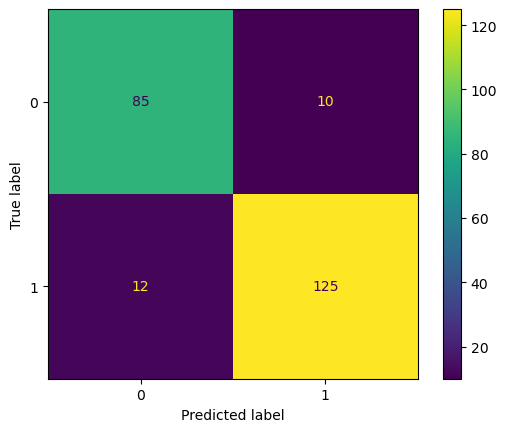

In [14]:
y_test_pred_logreg = logreg_gs.predict(X_test)
print(classification_report(y_test, y_test_pred_logreg))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_logreg);

In [15]:
# create a new dataframe that shows the performance of the model
# the true and predicted labels will be shown side-to-side,
# and a third column will display whether the model did a correct prediction,
# displaying "incorrect" if the values of the "true label" and "predicted label"
# differ from one another
# for readability, the encoded labels will be reverted back to their original
# values (DC Comics and Marvel Comics)

results_logreg = pd.DataFrame({"hist_text_classic": X_test, 
                              "true_label": y_test,
                              "predicted_label": y_test_pred_logreg,
                              "result": ["Correct" if true == pred else "Incorrect" for true, pred in zip(y_test, y_test_pred_logreg)],
                              "n_words": [len(text.split()) for text in X_test]
                              })

results_logreg.true_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)
results_logreg.predicted_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)

In [16]:
results_logreg.to_csv("data/error_logreg.csv",
                      index=False)

#### 2.2 K-Nearest Neighbours

In [17]:
pp.pprint(sorted(knn_pipe.get_params().keys()))

['kneighborsclassifier',
 'kneighborsclassifier__algorithm',
 'kneighborsclassifier__leaf_size',
 'kneighborsclassifier__metric',
 'kneighborsclassifier__metric_params',
 'kneighborsclassifier__n_jobs',
 'kneighborsclassifier__n_neighbors',
 'kneighborsclassifier__p',
 'kneighborsclassifier__weights',
 'memory',
 'robustscaler',
 'robustscaler__copy',
 'robustscaler__quantile_range',
 'robustscaler__unit_variance',
 'robustscaler__with_centering',
 'robustscaler__with_scaling',
 'steps',
 'tfidfvectorizer',
 'tfidfvectorizer__analyzer',
 'tfidfvectorizer__binary',
 'tfidfvectorizer__decode_error',
 'tfidfvectorizer__dtype',
 'tfidfvectorizer__encoding',
 'tfidfvectorizer__input',
 'tfidfvectorizer__lowercase',
 'tfidfvectorizer__max_df',
 'tfidfvectorizer__max_features',
 'tfidfvectorizer__min_df',
 'tfidfvectorizer__ngram_range',
 'tfidfvectorizer__norm',
 'tfidfvectorizer__preprocessor',
 'tfidfvectorizer__smooth_idf',
 'tfidfvectorizer__stop_words',
 'tfidfvectorizer__strip_accents'

In [18]:
knn_params = [{
    "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2,3)],
    "kneighborsclassifier__metric": ["cosine", "euclidean", "manhattan"],
    "kneighborsclassifier__n_neighbors": [1, 2, 3, 5, 7],
    "kneighborsclassifier__weights": ["uniform", "distance"]
    }]

In [19]:
knn_gs = GridSearchCV(knn_pipe,
                      knn_params,
                      cv=10,
                      scoring='f1_macro',
                      n_jobs=-1,
                      refit=True,
                      verbose=1)
knn_gs.fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=512)),
                                       ('robustscaler',
                                        RobustScaler(with_centering=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'kneighborsclassifier__metric': ['cosine',
                                                           'euclidean',
                                                           'manhattan'],
                          'kneighborsclassifier__n_neighbors': [1, 2, 3, 5, 7],
                          'kneighborsclassifier__weights': ['uniform',
                                                            'distance'],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                           (2, 3)]}],
             scoring='f1_macro', verbose=1)

In [20]:
knn_gs.best_estimator_

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=512, ngram_range=(2, 3))),
                ('robustscaler', RobustScaler(with_centering=False)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='cosine', n_neighbors=7))])

In [21]:
knn_gs.best_score_

0.89171749127019

In [22]:
knn_gs.best_params_

{'kneighborsclassifier__metric': 'cosine',
 'kneighborsclassifier__n_neighbors': 7,
 'kneighborsclassifier__weights': 'uniform',
 'tfidfvectorizer__ngram_range': (2, 3)}

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        95
           1       0.95      0.91      0.93       137

    accuracy                           0.92       232
   macro avg       0.91      0.92      0.92       232
weighted avg       0.92      0.92      0.92       232



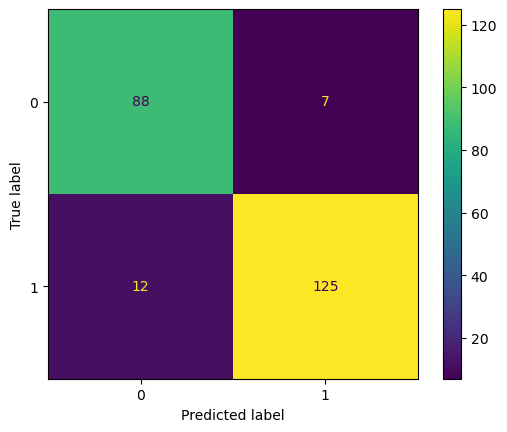

In [23]:
y_test_pred_knn = knn_gs.predict(X_test)
print(classification_report(y_test, y_test_pred_knn))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_knn);

In [24]:
results_knn = pd.DataFrame({"hist_text_classic": X_test, 
                            "true_label": y_test,
                            "predicted_label": y_test_pred_knn,
                            "result": ["Correct" if true == pred else "Incorrect" for true, pred in zip(y_test, y_test_pred_knn)],
                            "n_words": [len(text.split()) for text in X_test]
                            })

results_knn.true_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)
results_knn.predicted_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)

In [25]:
results_knn.to_csv("data/error_knn.csv",
                    index=False)

#### 2.3 Support Vector Machines

In [26]:
pp.pprint(sorted(svm_pipe.get_params().keys()))

['memory',
 'robustscaler',
 'robustscaler__copy',
 'robustscaler__quantile_range',
 'robustscaler__unit_variance',
 'robustscaler__with_centering',
 'robustscaler__with_scaling',
 'steps',
 'svc',
 'svc__C',
 'svc__break_ties',
 'svc__cache_size',
 'svc__class_weight',
 'svc__coef0',
 'svc__decision_function_shape',
 'svc__degree',
 'svc__gamma',
 'svc__kernel',
 'svc__max_iter',
 'svc__probability',
 'svc__random_state',
 'svc__shrinking',
 'svc__tol',
 'svc__verbose',
 'tfidfvectorizer',
 'tfidfvectorizer__analyzer',
 'tfidfvectorizer__binary',
 'tfidfvectorizer__decode_error',
 'tfidfvectorizer__dtype',
 'tfidfvectorizer__encoding',
 'tfidfvectorizer__input',
 'tfidfvectorizer__lowercase',
 'tfidfvectorizer__max_df',
 'tfidfvectorizer__max_features',
 'tfidfvectorizer__min_df',
 'tfidfvectorizer__ngram_range',
 'tfidfvectorizer__norm',
 'tfidfvectorizer__preprocessor',
 'tfidfvectorizer__smooth_idf',
 'tfidfvectorizer__stop_words',
 'tfidfvectorizer__strip_accents',
 'tfidfvectoriz

In [27]:
svm_params = [{
    "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2,3)],
    "svc__C": [0.1, 1, 10, 100],
    "svc__class_weight": [None, "balanced", c_weights],
    "svc__gamma": [0.0001, 0.001, 0.01, 0.1, 1],
    "svc__kernel": ["rbf", "linear"]
    }]

In [28]:
svm_gs = GridSearchCV(svm_pipe,
                      svm_params,
                      cv=10,
                      scoring='f1_macro',
                      n_jobs=-1,
                      refit=True,
                      verbose=1)
svm_gs.fit(X_train, y_train)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=512)),
                                       ('robustscaler',
                                        RobustScaler(with_centering=False)),
                                       ('svc', SVC(random_state=256))]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.1, 1, 10, 100],
                          'svc__class_weight': [None, 'balanced',
                                                {0: 1.45, 1: 1.0}],
                          'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                          'svc__kernel': ['rbf', 'linear'],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                           (2, 3)]}],
             scoring='f1_macro', verbose=1)

In [29]:
svm_gs.best_score_

0.9277006235561804

In [30]:
svm_gs.best_params_

{'svc__C': 1,
 'svc__class_weight': {0: 1.45, 1: 1.0},
 'svc__gamma': 0.0001,
 'svc__kernel': 'linear',
 'tfidfvectorizer__ngram_range': (1, 1)}

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        95
           1       0.95      0.91      0.93       137

    accuracy                           0.92       232
   macro avg       0.91      0.92      0.92       232
weighted avg       0.92      0.92      0.92       232



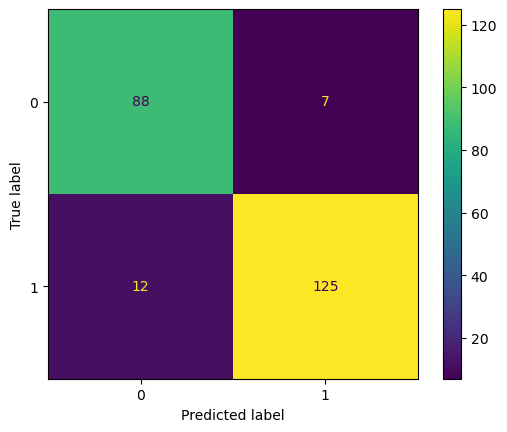

In [31]:
y_test_pred_svm = svm_gs.predict(X_test)
print(classification_report(y_test, y_test_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_svm);

In [32]:
results_svm = pd.DataFrame({"hist_text_classic": X_test, 
                            "true_label": y_test,
                            "predicted_label": y_test_pred_svm,
                            "result": ["Correct" if true == pred else "Incorrect" for true, pred in zip(y_test, y_test_pred_svm)],
                            "n_words": [len(text.split()) for text in X_test]
                            })

results_svm.true_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)
results_svm.predicted_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)

In [33]:
results_svm.to_csv("data/error_svm.csv",
                    index=False)

#### 2.4 Multinominal Naive Bayes


In [34]:
pp.pprint(sorted(nb_pipe.get_params().keys()))

['memory',
 'multinomialnb',
 'multinomialnb__alpha',
 'multinomialnb__class_prior',
 'multinomialnb__fit_prior',
 'multinomialnb__force_alpha',
 'robustscaler',
 'robustscaler__copy',
 'robustscaler__quantile_range',
 'robustscaler__unit_variance',
 'robustscaler__with_centering',
 'robustscaler__with_scaling',
 'steps',
 'tfidfvectorizer',
 'tfidfvectorizer__analyzer',
 'tfidfvectorizer__binary',
 'tfidfvectorizer__decode_error',
 'tfidfvectorizer__dtype',
 'tfidfvectorizer__encoding',
 'tfidfvectorizer__input',
 'tfidfvectorizer__lowercase',
 'tfidfvectorizer__max_df',
 'tfidfvectorizer__max_features',
 'tfidfvectorizer__min_df',
 'tfidfvectorizer__ngram_range',
 'tfidfvectorizer__norm',
 'tfidfvectorizer__preprocessor',
 'tfidfvectorizer__smooth_idf',
 'tfidfvectorizer__stop_words',
 'tfidfvectorizer__strip_accents',
 'tfidfvectorizer__sublinear_tf',
 'tfidfvectorizer__token_pattern',
 'tfidfvectorizer__tokenizer',
 'tfidfvectorizer__use_idf',
 'tfidfvectorizer__vocabulary',
 'verb

In [35]:
nb_params = [{
    "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2,3)],
    "multinomialnb__alpha": [000.1, 00.1, 0.1, 0.5, 1, 10]
    }]

In [36]:
nb_gs = GridSearchCV(nb_pipe,
                     nb_params,
                     cv=10,
                     scoring='f1_macro',
                     n_jobs=-1,
                     refit=True,
                     verbose=1)
nb_gs.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=512)),
                                       ('robustscaler',
                                        RobustScaler(with_centering=False)),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'multinomialnb__alpha': [0.1, 0.1, 0.1, 0.5, 1, 10],
                          'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                           (2, 3)]}],
             scoring='f1_macro', verbose=1)

In [37]:
nb_gs.best_score_

0.9076078032110857

In [38]:
nb_gs.best_params_

{'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (2, 3)}

              precision    recall  f1-score   support

           0       0.98      0.85      0.91        95
           1       0.91      0.99      0.94       137

    accuracy                           0.93       232
   macro avg       0.94      0.92      0.93       232
weighted avg       0.93      0.93      0.93       232



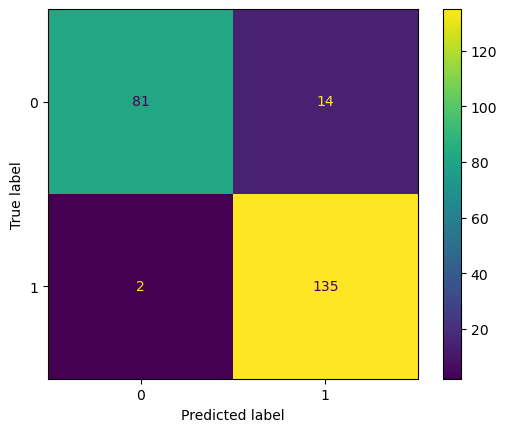

In [39]:
y_test_pred_nb = nb_gs.predict(X_test)
print(classification_report(y_test, y_test_pred_nb))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_nb);

In [40]:
results_nb = pd.DataFrame({"hist_text_classic": X_test, 
                            "true_label": y_test,
                            "predicted_label": y_test_pred_nb,
                            "result": ["Correct" if true == pred else "Incorrect" for true, pred in zip(y_test, y_test_pred_nb)],
                            "n_words": [len(text.split()) for text in X_test]
                            })

results_nb.true_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)
results_nb.predicted_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)

In [41]:
results_nb.to_csv("data/error_nb.csv",
                  index=False)

### 3 Error analysis

In [42]:
results_logreg[results_logreg["result"]=="Incorrect"]

,hist_text_classic,true_label,predicted_label,result,n_words
1238,max save magda gas chamber execution ; member ...,Marvel Comics,DC Comics,Incorrect,269
494,vic stone son pair scientist decide use test s...,DC Comics,Marvel Comics,Incorrect,245
1175,sam stern little slow - witte laborer complete...,Marvel Comics,DC Comics,Incorrect,135
1584,"vic sage , television investigative journalist...",DC Comics,Marvel Comics,Incorrect,318
2071,mary macpherran bear prematurely suburb denver...,Marvel Comics,DC Comics,Incorrect,131
759,flash thompson bully - turn selfless - soldier...,Marvel Comics,DC Comics,Incorrect,166
1481,dr . rudy jones ( die november 2016 ) research...,DC Comics,Marvel Comics,Incorrect,30
155,"albert "" al "" rothstein ( die october 6 , 2015...",DC Comics,Marvel Comics,Incorrect,30
2139,"vili 2 brother odin ve , asgardian war frost g...",Marvel Comics,DC Comics,Incorrect,65
330,"jaime assistance , start develop free independ...",DC Comics,Marvel Comics,Incorrect,194


In [43]:
results_knn[results_knn["result"]=="Incorrect"]

,hist_text_classic,true_label,predicted_label,result,n_words
1238,max save magda gas chamber execution ; member ...,Marvel Comics,DC Comics,Incorrect,269
494,vic stone son pair scientist decide use test s...,DC Comics,Marvel Comics,Incorrect,245
302,"channel positive energy , blackwulf able slice...",Marvel Comics,DC Comics,Incorrect,210
1615,arsenal later come conflict vandal savage . sa...,DC Comics,Marvel Comics,Incorrect,281
1951,"decide stay future work legion , give flight r...",DC Comics,Marvel Comics,Incorrect,254
1797,"apparently shatterstar body merge russell , re...",Marvel Comics,DC Comics,Incorrect,216
1150,korg kronan warrior reside sakaar force partic...,Marvel Comics,DC Comics,Incorrect,41
2035,defense inject serum change lizard prevent osc...,Marvel Comics,DC Comics,Incorrect,42
2071,mary macpherran bear prematurely suburb denver...,Marvel Comics,DC Comics,Incorrect,131
371,nathan summer ' birth carefully orchestrate ge...,Marvel Comics,DC Comics,Incorrect,309


In [44]:
results_svm[results_svm["result"]=="Incorrect"]

,hist_text_classic,true_label,predicted_label,result,n_words
2045,"jonathan crane derange , criminally insane tee...",DC Comics,Marvel Comics,Incorrect,219
1238,max save magda gas chamber execution ; member ...,Marvel Comics,DC Comics,Incorrect,269
2040,montoya longstanding detective gcpd select que...,DC Comics,Marvel Comics,Incorrect,23
494,vic stone son pair scientist decide use test s...,DC Comics,Marvel Comics,Incorrect,245
302,"channel positive energy , blackwulf able slice...",Marvel Comics,DC Comics,Incorrect,210
1175,sam stern little slow - witte laborer complete...,Marvel Comics,DC Comics,Incorrect,135
174,"roberto velasquez talented boxer , spar friend...",Marvel Comics,DC Comics,Incorrect,290
2071,mary macpherran bear prematurely suburb denver...,Marvel Comics,DC Comics,Incorrect,131
759,flash thompson bully - turn selfless - soldier...,Marvel Comics,DC Comics,Incorrect,166
2139,"vili 2 brother odin ve , asgardian war frost g...",Marvel Comics,DC Comics,Incorrect,65


In [45]:
results_nb[results_nb["result"]=="Incorrect"]

,hist_text_classic,true_label,predicted_label,result,n_words
2040,montoya longstanding detective gcpd select que...,DC Comics,Marvel Comics,Incorrect,23
979,infinity man combine form forever people .,DC Comics,Marvel Comics,Incorrect,7
557,kindly one arrive dream allow destroy order sa...,DC Comics,Marvel Comics,Incorrect,14
703,record whereabouts mighty sorcerer know felix ...,DC Comics,Marvel Comics,Incorrect,18
1166,lagoon boy originally underwater city atlantis...,DC Comics,Marvel Comics,Incorrect,12
1481,dr . rudy jones ( die november 2016 ) research...,DC Comics,Marvel Comics,Incorrect,30
1456,jean - paul beaubier parent kill car crash sho...,Marvel Comics,DC Comics,Incorrect,303
706,"cannonball overpower feral , old friend lucia ...",Marvel Comics,DC Comics,Incorrect,30
637,"crisis , dawn granger london mother . mother ,...",DC Comics,Marvel Comics,Incorrect,87
56,"have drink , rowdy guest penguin use gimmick u...",DC Comics,Marvel Comics,Incorrect,11
